In [3]:
# Análisis y Pronóstico de Dengue con CNN (Convolutional Neural Network) y Optuna
# ====================================================================================

# Imports necesarios
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Para machine learning y deep learning
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import optuna

# Configuración de plots
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)

# Configurar dispositivo
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Usando dispositivo: {device}")

Usando dispositivo: cuda


In [4]:
# =================================================================
# 1. CARGA Y EXPLORACIÓN INICIAL DE DATOS
# =================================================================

def load_and_explore_data():
    """Carga y realiza exploración inicial de los datos"""
    
    # Cargar datos
    df_train = pd.read_parquet('../../Datos/df_train.parquet')
    df_test = pd.read_parquet('../../Datos/df_test.parquet')
    
    print("=== INFORMACIÓN BÁSICA DE LOS DATASETS ===")
    print(f"Dataset de entrenamiento: {df_train.shape}")
    print(f"Dataset de prueba: {df_test.shape}")
    
    print("\n=== COLUMNAS DISPONIBLES ===")
    print("Entrenamiento:", df_train.columns.tolist())
    print("Prueba:", df_test.columns.tolist())
    
    print("\n=== INFORMACIÓN DETALLADA - ENTRENAMIENTO ===")
    print(df_train.info())
    
    print("\n=== ESTADÍSTICAS DESCRIPTIVAS ===")
    print(df_train.describe())
    
    print("\n=== VALORES NULOS ===")
    print("Entrenamiento:")
    print(df_train.isnull().sum())
    print("\nPrueba:")
    print(df_test.isnull().sum())
    
    print("\n=== RANGO DE AÑOS Y SEMANAS ===")
    print("Entrenamiento:")
    print(f"Años: {df_train['anio'].min()} - {df_train['anio'].max()}")
    print(f"Semanas: {df_train['semana'].min()} - {df_train['semana'].max()}")
    print(f"Barrios únicos: {df_train['id_bar'].nunique()}")
    
    print("\nPrueba:")
    print(f"Años: {df_test['anio'].min()} - {df_test['anio'].max()}")
    print(f"Semanas: {df_test['semana'].min()} - {df_test['semana'].max()}")
    print(f"Barrios únicos: {df_test['id_bar'].nunique()}")
    
    return df_train, df_test

In [5]:
# =================================================================
# 2. ANÁLISIS EXPLORATORIO DE DATOS (EDA)
# =================================================================

def perform_eda(df_train):
    """Realiza análisis exploratorio enfocado en patrones que CNN puede capturar"""
    
    print("=== ANÁLISIS EXPLORATORIO DE DATOS (CNN) ===")
    
    # Crear figura con subplots
    fig, axes = plt.subplots(3, 2, figsize=(20, 18))
    fig.suptitle('Análisis Exploratorio de Datos - Dengue (CNN)', fontsize=16, fontweight='bold')
    
    # 1. Distribución con análisis de frecuencias
    axes[0,0].hist(df_train['dengue'], bins=50, alpha=0.7, color='skyblue', edgecolor='black')
    axes[0,0].set_title('Distribución de Casos de Dengue\n(CNN: Detección de patrones locales)')
    axes[0,0].set_xlabel('Casos de Dengue')
    axes[0,0].set_ylabel('Frecuencia')
    
    # Añadir análisis de modos
    mode_value = df_train['dengue'].mode().iloc[0]
    axes[0,0].axvline(df_train['dengue'].mean(), color='red', linestyle='--', 
                      label=f'Media: {df_train["dengue"].mean():.2f}')
    axes[0,0].axvline(mode_value, color='green', linestyle='--', 
                      label=f'Moda: {mode_value:.2f}')
    axes[0,0].legend()
    
    # 2. Señal temporal con análisis de frecuencia
    df_temp = df_train.groupby(['anio', 'semana'])['dengue'].sum().reset_index()
    df_temp['fecha'] = pd.to_datetime(df_temp['anio'].astype(str) + '-W' + 
                                      df_temp['semana'].astype(str).str.zfill(2) + '-1', 
                                      format='%Y-W%W-%w')
    
    axes[0,1].plot(df_temp['fecha'], df_temp['dengue'], marker='o', markersize=2, alpha=0.8, linewidth=1)
    axes[0,1].set_title('Señal Temporal de Dengue\n(CNN: Convoluciones capturan patrones)')
    axes[0,1].set_xlabel('Fecha')
    axes[0,1].set_ylabel('Casos Totales de Dengue')
    axes[0,1].tick_params(axis='x', rotation=45)
    
    # Resaltar picos (para mostrar qué busca CNN)
    rolling_mean = df_temp['dengue'].rolling(4).mean()
    rolling_std = df_temp['dengue'].rolling(4).std()
    peaks = df_temp['dengue'] > (rolling_mean + 1.5 * rolling_std)
    axes[0,1].scatter(df_temp['fecha'][peaks], df_temp['dengue'][peaks], 
                      color='red', s=30, alpha=0.7, label='Picos detectables')
    axes[0,1].legend()
    
    # 3. Análisis espectral (frecuencias dominantes)
    sample_barrio = df_train.groupby('id_bar').size().idxmax()
    barrio_data = df_train[df_train['id_bar'] == sample_barrio].sort_values(['anio', 'semana'])
    dengue_signal = barrio_data['dengue'].values
    
    # FFT para análisis de frecuencias
    if len(dengue_signal) > 8:
        fft = np.fft.fft(dengue_signal)
        freqs = np.fft.fftfreq(len(dengue_signal))
        magnitude = np.abs(fft)
        
        # Solo frecuencias positivas
        positive_freqs = freqs[:len(freqs)//2]
        positive_magnitude = magnitude[:len(magnitude)//2]
        
        axes[1,0].plot(positive_freqs[1:], positive_magnitude[1:], linewidth=2)
        axes[1,0].set_title(f'Espectro de Frecuencias (Barrio {sample_barrio})\n(CNN: Filtros para diferentes frecuencias)')
        axes[1,0].set_xlabel('Frecuencia')
        axes[1,0].set_ylabel('Magnitud')
        axes[1,0].grid(True, alpha=0.3)
    
    # 4. Convolución manual para demostrar concepto
    # Simular diferentes kernels de CNN
    kernels = {
        'Tendencia': np.array([-1, 0, 1]),  # Detector de tendencia
        'Pico': np.array([-1, 2, -1]),      # Detector de picos
        'Suavizado': np.array([1, 2, 1]) / 4  # Filtro de suavizado
    }
    
    sample_signal = dengue_signal[:min(50, len(dengue_signal))]
    
    for i, (name, kernel) in enumerate(kernels.items()):
        if len(sample_signal) > len(kernel):
            convolved = np.convolve(sample_signal, kernel, mode='valid')
            axes[1,1].plot(convolved, label=f'Kernel {name}', alpha=0.8, linewidth=2)
    
    axes[1,1].set_title('Simulación de Kernels CNN\n(Diferentes filtros detectan diferentes patrones)')
    axes[1,1].set_xlabel('Tiempo')
    axes[1,1].set_ylabel('Respuesta del Filtro')
    axes[1,1].legend()
    axes[1,1].grid(True, alpha=0.3)
    
    # 5. Patrones multi-escala (lo que CNN captura naturalmente)
    seasonal_weekly = df_train.groupby('semana')['dengue'].mean()
    seasonal_monthly = df_train.groupby(df_train['semana'] // 4)['dengue'].mean()  # Aproximación mensual
    
    ax1 = axes[2,0]
    ax2 = ax1.twinx()
    
    line1 = ax1.plot(seasonal_weekly.index, seasonal_weekly.values, 'b-', 
                     marker='o', markersize=3, label='Patrón Semanal', alpha=0.7)
    line2 = ax2.plot(seasonal_monthly.index * 4, seasonal_monthly.values, 'r-', 
                     marker='s', markersize=4, label='Patrón Mensual', linewidth=2)
    
    ax1.set_xlabel('Semana del Año')
    ax1.set_ylabel('Casos Promedio (Semanal)', color='b')
    ax2.set_ylabel('Casos Promedio (Mensual)', color='r')
    ax1.set_title('Patrones Multi-Escala\n(CNN: Kernels de diferentes tamaños)')
    
    # Combinar leyendas
    lines = line1 + line2
    labels = [l.get_label() for l in lines]
    ax1.legend(lines, labels, loc='upper right')
    ax1.grid(True, alpha=0.3)
    
    # 6. Correlación espacial entre características (para CNN multi-canal)
    feature_matrix = df_train[['lluvia_mean', 'temperatura_mean', 'dengue']].corr()
    im = axes[2,1].imshow(feature_matrix.values, cmap='RdYlBu_r', vmin=-1, vmax=1)
    
    axes[2,1].set_title('Correlación entre Canales\n(CNN: Multi-canal como imagen RGB)')
    axes[2,1].set_xticks(range(len(feature_matrix.columns)))
    axes[2,1].set_yticks(range(len(feature_matrix.columns)))
    axes[2,1].set_xticklabels(['Lluvia', 'Temperatura', 'Dengue'])
    axes[2,1].set_yticklabels(['Lluvia', 'Temperatura', 'Dengue'])
    
    # Añadir valores de correlación
    for i in range(len(feature_matrix.columns)):
        for j in range(len(feature_matrix.columns)):
            axes[2,1].text(j, i, f'{feature_matrix.iloc[i, j]:.2f}', 
                          ha='center', va='center', fontweight='bold')
    
    plt.colorbar(im, ax=axes[2,1], label='Correlación')
    
    plt.tight_layout()
    plt.show()
    
    # Análisis específico para CNN: Patrones convolucionables
    plt.figure(figsize=(20, 6))
    
    # Subplot 1: Análisis de patrones repetitivos
    plt.subplot(1, 4, 1)
    series_lengths = df_train.groupby('id_bar').size()
    plt.hist(series_lengths, bins=20, alpha=0.7, color='lightcoral', edgecolor='black')
    plt.title('Longitud de Series\n(CNN: Necesita secuencias largas)')
    plt.xlabel('Observaciones por Barrio')
    plt.ylabel('Frecuencia')
    plt.axvline(series_lengths.mean(), color='red', linestyle='--', 
                label=f'Media: {series_lengths.mean():.1f}')
    
    # Línea de longitud mínima recomendada para CNN
    min_cnn_length = 20
    plt.axvline(min_cnn_length, color='green', linestyle='--', 
                label=f'Mín. CNN: {min_cnn_length}')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Subplot 2: Análisis de periodicidad
    plt.subplot(1, 4, 2)
    # Autocorrelación para encontrar periodicidades
    max_lag = min(26, len(dengue_signal) - 1)
    autocorr_cnn = []
    
    for lag in range(1, max_lag + 1):
        if len(dengue_signal) > lag:
            corr = np.corrcoef(dengue_signal[:-lag], dengue_signal[lag:])[0,1]
            autocorr_cnn.append(corr if not np.isnan(corr) else 0)
        else:
            autocorr_cnn.append(0)
    
    plt.plot(range(1, len(autocorr_cnn) + 1), autocorr_cnn, 'o-', markersize=4, linewidth=2)
    plt.title('Autocorrelación\n(CNN: Detecta periodicidad)')
    plt.xlabel('Lag (semanas)')
    plt.ylabel('Autocorrelación')
    plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
    
    # Resaltar picos significativos
    significant_lags = np.where(np.array(autocorr_cnn) > 0.2)[0] + 1
    if len(significant_lags) > 0:
        plt.scatter(significant_lags, np.array(autocorr_cnn)[significant_lags - 1], 
                   color='red', s=50, label=f'Períodos: {significant_lags}', zorder=5)
        plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Subplot 3: Variabilidad temporal (importante para CNN)
    plt.subplot(1, 4, 3)
    # Calcular variabilidad local usando ventana deslizante
    window_size = 4
    local_variance = []
    
    for i in range(window_size, len(dengue_signal)):
        window = dengue_signal[i-window_size:i]
        local_variance.append(np.var(window))
    
    plt.plot(local_variance, linewidth=2, alpha=0.8)
    plt.title('Variabilidad Local\n(CNN: Adapta a diferentes escalas)')
    plt.xlabel('Posición Temporal')
    plt.ylabel('Varianza Local')
    
    # Resaltar regiones de alta variabilidad
    high_var_threshold = np.percentile(local_variance, 75)
    high_var_regions = np.array(local_variance) > high_var_threshold
    plt.fill_between(range(len(local_variance)), 0, local_variance, 
                     where=high_var_regions, alpha=0.3, color='red', 
                     label='Alta variabilidad')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Subplot 4: Análisis de gradientes (lo que CNN optimiza)
    plt.subplot(1, 4, 4)
    # Calcular gradientes temporales
    gradients = np.gradient(dengue_signal)
    
    plt.hist(gradients, bins=20, alpha=0.7, color='purple', edgecolor='black', density=True)
    plt.title('Distribución de Gradientes\n(CNN: Optimiza detección de cambios)')
    plt.xlabel('Gradiente Temporal')
    plt.ylabel('Densidad')
    plt.axvline(np.mean(gradients), color='red', linestyle='--', 
                label=f'Media: {np.mean(gradients):.2f}')
    plt.axvline(0, color='black', linestyle='-', alpha=0.5)
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print(f"\n=== ESTADÍSTICAS PARA CNN ===")
    print(f"Longitud promedio de series: {series_lengths.mean():.1f}")
    print(f"Series apropiadas para CNN (≥20): {(series_lengths >= 20).sum()}")
    print(f"Periodicidad detectada en lags: {significant_lags if len(significant_lags) > 0 else 'No significativa'}")
    print(f"Variabilidad temporal promedio: {np.mean(local_variance):.3f}")
    print(f"Rango de gradientes: [{np.min(gradients):.2f}, {np.max(gradients):.2f}]")
    
    return series_lengths

In [6]:
# =================================================================
# 3. PREPARACIÓN DE DATOS PARA CNN
# =================================================================

def prepare_cnn_data(df_train, df_test, sequence_length=20):
    """Prepara los datos específicamente para CNN 1D"""
    
    print("=== PREPARACIÓN DE DATOS PARA CNN ===")
    print(f"Longitud de secuencia: {sequence_length}")
    
    # Crear características específicas para CNN
    def add_cnn_features(df):
        df = df.copy()
        
        # Características temporales para múltiples canales
        df['semana_sin'] = np.sin(2 * np.pi * df['semana'] / 52)
        df['semana_cos'] = np.cos(2 * np.pi * df['semana'] / 52)
        
        # Características de diferentes escalas temporales (multi-resolución)
        df['semana_sin_2'] = np.sin(4 * np.pi * df['semana'] / 52)  # Doble frecuencia
        df['semana_cos_2'] = np.cos(4 * np.pi * df['semana'] / 52)
        df['semana_sin_4'] = np.sin(8 * np.pi * df['semana'] / 52)  # Cuádruple frecuencia
        df['semana_cos_4'] = np.cos(8 * np.pi * df['semana'] / 52)
        
        # Características categóricas suavizadas
        df['trimestre_norm'] = ((df['semana'] - 1) // 13) / 3.0  # Normalizado [0,1]
        df['temporada_lluvia'] = np.sin(2 * np.pi * (df['semana'] - 14) / 26)  # Centrado en temporada lluvia
        
        # Interacciones no lineales (CNN las puede capturar mejor)
        df['lluvia_cuadratica'] = df['lluvia_mean'] ** 2
        df['temp_cuadratica'] = df['temperatura_mean'] ** 2
        df['lluvia_temp_producto'] = df['lluvia_mean'] * df['temperatura_mean']
        
        # Características de orden superior
        df['clima_complexity'] = (df['lluvia_var'] + df['temperatura_var']) / 2
        df['estabilidad_climatica'] = 1 / (df['lluvia_var'] + df['temperatura_var'] + 1e-8)
        
        return df
    
    # Combinar datasets
    df_combined = pd.concat([df_train, df_test], ignore_index=True)
    df_combined = df_combined.sort_values(['id_bar', 'anio', 'semana']).reset_index(drop=True)
    
    # Agregar características para CNN
    df_combined = add_cnn_features(df_combined)
    
    # Crear características de diferencias (gradientes temporales)
    def create_gradient_features(df, target_col='dengue'):
        df = df.copy()
        
        # Gradientes de primer orden
        df[f'{target_col}_grad1'] = df.groupby('id_bar')[target_col].diff()
        
        # Gradientes de segundo orden (aceleración)
        df[f'{target_col}_grad2'] = df.groupby('id_bar')[f'{target_col}_grad1'].diff()
        
        # Gradientes suavizados
        df[f'{target_col}_grad_smooth'] = (
            df.groupby('id_bar')[target_col].rolling(3).apply(
                lambda x: (x.iloc[-1] - x.iloc[0]) / 2 if len(x) >= 3 else 0
            ).reset_index(0, drop=True)
        )
        
        # Características de momentum
        df[f'{target_col}_momentum_3'] = (
            df.groupby('id_bar')[target_col].rolling(3).apply(
                lambda x: np.sum(np.diff(x)) if len(x) >= 3 else 0
            ).reset_index(0, drop=True)
        )
        
        return df
    
    df_combined = create_gradient_features(df_combined)
    
    # Features para CNN (organizadas por canales conceptuales)
    base_features = [
        'ESTRATO', 'area_barrio', 'concentraciones', 'vivienda', 
        'equipesado', 'sumideros', 'maquina'
    ]
    
    climate_features = [
        'lluvia_mean', 'lluvia_var', 'lluvia_max', 'lluvia_min',
        'temperatura_mean', 'temperatura_var', 'temperatura_max', 'temperatura_min',
        'lluvia_cuadratica', 'temp_cuadratica', 'lluvia_temp_producto'
    ]
    
    temporal_features = [
        'semana_sin', 'semana_cos', 'semana_sin_2', 'semana_cos_2',
        'semana_sin_4', 'semana_cos_4', 'trimestre_norm', 'temporada_lluvia'
    ]
    
    derived_features = [
        'clima_complexity', 'estabilidad_climatica'
    ]
    
    # Agregar características de gradientes si existen
    gradient_features = [col for col in df_combined.columns if 'grad' in col or 'momentum' in col]
    
    # Combinar todas las características
    feature_cols = base_features + climate_features + temporal_features + derived_features + gradient_features
    available_features = [col for col in feature_cols if col in df_combined.columns]
    
    # Manejar valores faltantes
    for col in available_features:
        if df_combined[col].dtype in ['float64', 'int64']:
            # Interpolación lineal por barrio
            df_combined[col] = df_combined.groupby('id_bar')[col].transform(
                lambda x: x.interpolate(method='linear').fillna(x.median())
            )
            # Llenar valores restantes con mediana global
            df_combined[col] = df_combined[col].fillna(df_combined[col].median())
    
    print(f"Características organizadas para CNN:")
    print(f"  - Base: {len(base_features)}")
    print(f"  - Climáticas: {len(climate_features)}")
    print(f"  - Temporales: {len(temporal_features)}")
    print(f"  - Derivadas: {len(derived_features)}")
    print(f"  - Gradientes: {len(gradient_features)}")
    print(f"  - Total: {len(available_features)}")
    
    # Separar entrenamiento y test
    train_mask = df_combined['anio'] != 2022
    df_train_processed = df_combined[train_mask].copy()
    df_test_processed = df_combined[~train_mask].copy()
    
    # Crear secuencias para CNN (como "imágenes" 1D)
    def create_cnn_sequences(df, feature_cols, target_col='dengue', seq_length=sequence_length):
        sequences = []
        targets = []
        prediction_info = []
        
        for barrio in df['id_bar'].unique():
            barrio_data = df[df['id_bar'] == barrio].sort_values(['anio', 'semana'])
            
            if len(barrio_data) >= seq_length + 1:
                features = barrio_data[feature_cols].values
                target_values = barrio_data[target_col].values if target_col in barrio_data.columns else None
                
                for i in range(seq_length, len(barrio_data)):
                    # Secuencia como "imagen" 1D multi-canal
                    seq_features = features[i-seq_length:i]
                    sequences.append(seq_features)
                    
                    # Información de predicción
                    pred_info = {
                        'id_bar': barrio_data.iloc[i]['id_bar'],
                        'anio': barrio_data.iloc[i]['anio'],
                        'semana': barrio_data.iloc[i]['semana']
                    }
                    prediction_info.append(pred_info)
                    
                    # Target
                    if target_values is not None:
                        targets.append(target_values[i])
        
        sequences = np.array(sequences) if sequences else np.array([])
        targets = np.array(targets) if targets else None
        
        return sequences, targets, prediction_info
    
    # Crear secuencias de entrenamiento
    X_train, y_train, train_info = create_cnn_sequences(
        df_train_processed, available_features, 'dengue', sequence_length
    )
    
    # Crear secuencias de test
    X_test, _, test_info = create_cnn_sequences(
        df_test_processed, available_features, None, sequence_length
    )
    
    # Fallback para test si no hay suficientes secuencias
    if X_test.size == 0 or len(X_test) < len(df_test_processed):
        print("Creando secuencias de predicción usando contexto histórico...")
        
        X_test_list = []
        test_info_list = []
        
        for barrio in df_test_processed['id_bar'].unique():
            barrio_historical = df_train_processed[df_train_processed['id_bar'] == barrio]
            barrio_test = df_test_processed[df_test_processed['id_bar'] == barrio]
            
            if len(barrio_historical) >= sequence_length:
                # Usar contexto más reciente
                features_hist = barrio_historical[available_features].values[-sequence_length:]
                
                for _, row in barrio_test.iterrows():
                    X_test_list.append(features_hist)
                    test_info_list.append({
                        'id_bar': row['id_bar'],
                        'anio': row['anio'],
                        'semana': row['semana']
                    })
        
        if X_test_list:
            X_test = np.array(X_test_list)
            test_info = test_info_list
    
    print(f"\n=== SECUENCIAS CNN CREADAS ===")
    print(f"Entrenamiento: {X_train.shape if X_train.size > 0 else 'No hay secuencias'}")
    print(f"Targets entrenamiento: {y_train.shape if y_train is not None else 'N/A'}")
    print(f"Test: {X_test.shape if X_test.size > 0 else 'No hay secuencias'}")
    
    if X_train.size > 0:
        print(f"Forma de entrada CNN: (batch_size, seq_length, n_features) = (N, {X_train.shape[1]}, {X_train.shape[2]})")
    
    return X_train, y_train, X_test, test_info, available_features

In [7]:
# =================================================================
# 4. ARQUITECTURA CNN AVANZADA PARA SERIES DE TIEMPO
# =================================================================

class ResidualBlock1D(nn.Module):
    """Bloque residual para CNN 1D"""
    
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, dropout=0.1):
        super(ResidualBlock1D, self).__init__()
        
        padding = kernel_size // 2
        
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size, stride, padding)
        self.bn1 = nn.BatchNorm1d(out_channels)
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size, 1, padding)
        self.bn2 = nn.BatchNorm1d(out_channels)
        self.dropout = nn.Dropout(dropout)
        
        # Skip connection
        self.skip = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.skip = nn.Sequential(
                nn.Conv1d(in_channels, out_channels, 1, stride),
                nn.BatchNorm1d(out_channels)
            )
    
    def forward(self, x):
        residual = self.skip(x)
        
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.dropout(out)
        out = self.bn2(self.conv2(out))
        
        out += residual
        out = F.relu(out)
        
        return out

class AttentionModule1D(nn.Module):
    """Módulo de atención para secuencias temporales"""
    
    def __init__(self, in_channels):
        super(AttentionModule1D, self).__init__()
        
        self.attention = nn.Sequential(
            nn.Conv1d(in_channels, in_channels // 8, 1),
            nn.ReLU(),
            nn.Conv1d(in_channels // 8, 1, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        attention_weights = self.attention(x)
        return x * attention_weights

class DengueCNN(nn.Module):
    """CNN avanzada para predicción de dengue"""
    
    def __init__(self, input_features, num_filters=[32, 64, 128], kernel_sizes=[3, 5, 7], 
                 dropout_rate=0.2, use_attention=True, use_residual=True):
        super(DengueCNN, self).__init__()
        
        self.input_features = input_features
        self.use_attention = use_attention
        self.use_residual = use_residual
        
        # Convoluciones multi-escala (diferentes kernel sizes)
        self.multi_scale_convs = nn.ModuleList()
        
        for kernel_size in kernel_sizes:
            conv_layers = []
            in_channels = 1  # Empezamos con 1 canal (todas las features como un canal)
            
            for i, out_channels in enumerate(num_filters):
                if use_residual and i > 0:
                    conv_layers.append(ResidualBlock1D(in_channels, out_channels, kernel_size, 
                                                     stride=1, dropout=dropout_rate))
                else:
                    padding = kernel_size // 2
                    conv_layers.extend([
                        nn.Conv1d(in_channels, out_channels, kernel_size, padding=padding),
                        nn.BatchNorm1d(out_channels),
                        nn.ReLU(),
                        nn.Dropout(dropout_rate)
                    ])
                in_channels = out_channels
            
            # Pooling adaptativo para cada escala
            conv_layers.append(nn.AdaptiveAvgPool1d(4))  # Reduce a 4 elementos por canal
            
            self.multi_scale_convs.append(nn.Sequential(*conv_layers))
        
        # Atención si está habilitada
        if use_attention:
            self.attention_modules = nn.ModuleList([
                AttentionModule1D(num_filters[-1]) for _ in kernel_sizes
            ])
        
        # Combinar características de múltiples escalas
        combined_features = len(kernel_sizes) * num_filters[-1] * 4
        
        # Capas densas finales
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(combined_features, combined_features // 2),
            nn.ReLU(),
            nn.BatchNorm1d(combined_features // 2),
            nn.Dropout(dropout_rate),
            
            nn.Linear(combined_features // 2, combined_features // 4),
            nn.ReLU(),
            nn.BatchNorm1d(combined_features // 4),
            nn.Dropout(dropout_rate * 0.5),
            
            nn.Linear(combined_features // 4, 64),
            nn.ReLU(),
            nn.Dropout(dropout_rate * 0.3),
            
            nn.Linear(64, 1)
        )
        
        # Inicialización de pesos
        self.init_weights()
    
    def init_weights(self):
        """Inicialización especializada para CNN"""
        for m in self.modules():
            if isinstance(m, nn.Conv1d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm1d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        # x shape: (batch_size, seq_length, input_features)
        
        # Transponer para CNN: (batch_size, channels=1, seq_length * input_features)
        # Reorganizar como señal 1D con todas las features como un canal continuo
        batch_size, seq_length, input_features = x.shape
        x_reshaped = x.view(batch_size, 1, seq_length * input_features)
        
        # Procesar con cada escala de convolución
        multi_scale_outputs = []
        
        for i, conv_scale in enumerate(self.multi_scale_convs):
            scale_output = conv_scale(x_reshaped)
            
            # Aplicar atención si está habilitada
            if self.use_attention:
                scale_output = self.attention_modules[i](scale_output)
            
            multi_scale_outputs.append(scale_output)
        
        # Concatenar salidas de múltiples escalas
        combined = torch.cat(multi_scale_outputs, dim=1)
        
        # Clasificación final
        output = self.classifier(combined)
        
        return output.squeeze()

class CNNDengueDataset(Dataset):
    """Dataset específico para CNN con augmentación"""
    
    def __init__(self, sequences, targets=None, augment=False):
        self.sequences = torch.FloatTensor(sequences)
        self.targets = torch.FloatTensor(targets) if targets is not None else None
        self.augment = augment
        
    def __len__(self):
        return len(self.sequences)
    
    def __getitem__(self, idx):
        seq = self.sequences[idx]
        
        # Augmentación específica para CNN
        # --- CORRECCIÓN AQUÍ ---
        # Se elimina la referencia al atributo inexistente 'self.training'
        if self.augment:
            # Ruido aditivo
            noise = torch.randn_like(seq) * 0.01
            seq = seq + noise
            
            # Pequeña rotación temporal (shift)
            if torch.rand(1) > 0.7:
                shift = torch.randint(-2, 3, (1,)).item()
                seq = torch.roll(seq, shift, dims=0)
        
        if self.targets is not None:
            return seq, self.targets[idx]
        return seq

def train_cnn_model(model, train_loader, val_loader, num_epochs, learning_rate, device):
    """Entrena el modelo CNN con técnicas específicas"""
    
    # Función de pérdida
    criterion = nn.MSELoss()
    
    # Optimizador específico para CNN
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=1e-4)
    
    # Scheduler con warm restart (bueno para CNN)
    scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(
        optimizer, T_0=20, T_mult=1, eta_min=learning_rate/10
    )
    
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    patience_counter = 0
    early_stopping_patience = 30
    
    for epoch in range(num_epochs):
        # Entrenamiento
        model.train()
        train_loss = 0.0
        
        for batch_X, batch_y in train_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            
            # Regularización L1 ligera
            l1_lambda = 1e-5
            l1_norm = sum(p.abs().sum() for p in model.parameters() if p.dim() > 1)
            loss = loss + l1_lambda * l1_norm
            
            loss.backward()
            
            # Gradient clipping para CNN
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            optimizer.step()
            train_loss += loss.item()
        
        # Validación
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for batch_X, batch_y in val_loader:
                batch_X, batch_y = batch_X.to(device), batch_y.to(device)
                outputs = model(batch_X)
                loss = criterion(outputs, batch_y)
                val_loss += loss.item()
        
        train_loss /= len(train_loader)
        val_loss /= len(val_loader)
        
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        
        scheduler.step()
        
        # Early stopping
        if val_loss < best_val_loss * 0.995:
            best_val_loss = val_loss
            patience_counter = 0
        else:
            patience_counter += 1
        
        if patience_counter >= early_stopping_patience:
            print(f"Early stopping en época {epoch}")
            break
        
        if epoch % 25 == 0:
            current_lr = scheduler.get_last_lr()[0]
            print(f'Epoch {epoch}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, LR: {current_lr:.6f}')
    
    return train_losses, val_losses, best_val_loss


In [8]:
# =================================================================
# 5. OPTIMIZACIÓN CON OPTUNA
# =================================================================

def objective_cnn(trial, X_train, y_train, device):
    """Función objetivo para optimización de CNN con Optuna"""
    
    # Hiperparámetros específicos de CNN
    num_filters_base = trial.suggest_int('num_filters_base', 16, 64)
    num_layers = trial.suggest_int('num_layers', 2, 4)
    kernel_sizes = trial.suggest_categorical('kernel_sizes', [
        [3, 5], [3, 5, 7], [5, 7, 9], [3, 7, 11]
    ])
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.4)
    learning_rate = trial.suggest_float('learning_rate', 1e-4, 1e-2, log=True)
    batch_size = trial.suggest_categorical('batch_size', [16, 32, 64])
    use_attention = trial.suggest_categorical('use_attention', [True, False])
    use_residual = trial.suggest_categorical('use_residual', [True, False])
    
    # Crear arquitectura de filtros progresiva
    num_filters = [num_filters_base * (2 ** i) for i in range(num_layers)]
    
    # División temporal para validación
    split_idx = int(0.8 * len(X_train))
    X_tr, X_val = X_train[:split_idx], X_train[split_idx:]
    y_tr, y_val = y_train[:split_idx], y_train[split_idx:]
    
    # Datasets
    train_dataset = CNNDengueDataset(X_tr, y_tr, augment=True)
    val_dataset = CNNDengueDataset(X_val, y_val, augment=False)
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,
                             num_workers=0, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False,
                           num_workers=0, pin_memory=True)
    
    # Modelo CNN
    model = DengueCNN(
        input_features=X_train.shape[2],
        num_filters=num_filters,
        kernel_sizes=kernel_sizes,
        dropout_rate=dropout_rate,
        use_attention=use_attention,
        use_residual=use_residual
    ).to(device)
    
    # Entrenamiento
    _, _, best_val_loss = train_cnn_model(
        model, train_loader, val_loader, 
        num_epochs=100, learning_rate=learning_rate, device=device
    )
    
    return best_val_loss

def optimize_cnn_hyperparameters(X_train, y_train, n_trials=25):
    """Optimiza hiperparámetros del CNN con Optuna"""
    
    print(f"Optimizando hiperparámetros CNN con {n_trials} trials...")
    
    # Estudio con pruning
    study = optuna.create_study(
        direction='minimize',
        pruner=optuna.pruners.MedianPruner(n_startup_trials=3, n_warmup_steps=15)
    )
    
    study.optimize(lambda trial: objective_cnn(trial, X_train, y_train, device), 
                   n_trials=n_trials)
    
    print(f"Mejor valor de validación: {study.best_value:.4f}")
    print("Mejores hiperparámetros:")
    for key, value in study.best_params.items():
        print(f"  {key}: {value}")
    
    return study.best_params

In [9]:
# =================================================================
# 6. FUNCIÓN PRINCIPAL DE ENTRENAMIENTO Y PREDICCIÓN
# =================================================================

def train_and_predict_cnn():
    """Función principal que ejecuta todo el pipeline CNN"""
    
    print("=== INICIANDO PIPELINE DE ANÁLISIS Y PREDICCIÓN CON CNN ===")
    
    # 1. Cargar y explorar datos
    df_train, df_test = load_and_explore_data()
    
    # 2. Análisis exploratorio específico para CNN
    series_lengths = perform_eda(df_train)
    
    # 3. Determinar longitud de secuencia para CNN
    sequence_length = min(20, int(series_lengths.quantile(0.6)))  # CNN necesita secuencias moderadas
    print(f"\nLongitud de secuencia CNN seleccionada: {sequence_length}")
    
    # 4. Preparar datos para CNN
    X_train, y_train, X_test, test_info, feature_cols = prepare_cnn_data(df_train, df_test, sequence_length)
    
    if X_train.size == 0 or y_train is None:
        print("Error: No se pudieron crear secuencias de entrenamiento suficientes")
        return None, None, None
    
    # 5. Normalización específica para CNN
    print("\n=== NORMALIZACIÓN PARA CNN ===")
    
    # Reshape preservando estructura para CNN
    original_shape = X_train.shape
    X_train_reshaped = X_train.reshape(-1, X_train.shape[-1])
    X_test_reshaped = X_test.reshape(-1, X_test.shape[-1])
    
    # Normalización robusta
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_reshaped)
    X_test_scaled = scaler.transform(X_test_reshaped)
    
    # Clipping suave de outliers
    for i in range(X_train_scaled.shape[1]):
        p1, p99 = np.percentile(X_train_scaled[:, i], [2, 98])  # Menos agresivo que LSTM
        X_train_scaled[:, i] = np.clip(X_train_scaled[:, i], p1, p99)
        X_test_scaled[:, i] = np.clip(X_test_scaled[:, i], p1, p99)
    
    # Reshape de vuelta
    X_train_scaled = X_train_scaled.reshape(original_shape)
    X_test_scaled = X_test_scaled.reshape(X_test.shape)
    
    print(f"Datos escalados - Train: {X_train_scaled.shape}, Test: {X_test_scaled.shape}")
    print(f"Rango de datos: [{X_train_scaled.min():.2f}, {X_train_scaled.max():.2f}]")
    
    # 6. Optimizar hiperparámetros
    print("\n=== OPTIMIZACIÓN DE HIPERPARÁMETROS CNN ===")
    best_params = optimize_cnn_hyperparameters(X_train_scaled, y_train, n_trials=20)
    
    # 7. Entrenar modelo final
    print("\n=== ENTRENAMIENTO DEL MODELO CNN FINAL ===")
    
    # División para validación
    split_idx = int(0.8 * len(X_train_scaled))
    X_tr, X_val = X_train_scaled[:split_idx], X_train_scaled[split_idx:]
    y_tr, y_val = y_train[:split_idx], y_train[split_idx:]
    
    # Datasets finales
    train_dataset = CNNDengueDataset(X_tr, y_tr, augment=True)
    val_dataset = CNNDengueDataset(X_val, y_val, augment=False)
    test_dataset = CNNDengueDataset(X_test_scaled)
    
    train_loader = DataLoader(train_dataset, batch_size=best_params['batch_size'], 
                             shuffle=True, num_workers=0, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=best_params['batch_size'], 
                           shuffle=False, num_workers=0, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=best_params['batch_size'], 
                            shuffle=False, num_workers=0, pin_memory=True)
    
    # Crear arquitectura de filtros
    num_filters = [best_params['num_filters_base'] * (2 ** i) for i in range(best_params['num_layers'])]
    
    # Modelo final CNN
    final_model = DengueCNN(
        input_features=X_train_scaled.shape[2],
        num_filters=num_filters,
        kernel_sizes=best_params['kernel_sizes'],
        dropout_rate=best_params['dropout_rate'],
        use_attention=best_params['use_attention'],
        use_residual=best_params['use_residual']
    ).to(device)
    
    total_params = sum(p.numel() for p in final_model.parameters())
    trainable_params = sum(p.numel() for p in final_model.parameters() if p.requires_grad)
    
    print(f"Modelo CNN creado:")
    print(f"  - Parámetros totales: {total_params:,}")
    print(f"  - Parámetros entrenables: {trainable_params:,}")
    print(f"  - Arquitectura de filtros: {num_filters}")
    print(f"  - Kernel sizes: {best_params['kernel_sizes']}")
    print(f"  - Mecanismo de atención: {best_params['use_attention']}")
    print(f"  - Bloques residuales: {best_params['use_residual']}")
    
    # Entrenar modelo final
    train_losses, val_losses, _ = train_cnn_model(
        final_model, train_loader, val_loader, 
        num_epochs=250, learning_rate=best_params['learning_rate'], device=device
    )
    
    # 8. Validación del modelo
    print("\n=== VALIDACIÓN DEL MODELO CNN ===")
    final_model.eval()
    
    with torch.no_grad():
        val_predictions = []
        for batch_X in DataLoader(CNNDengueDataset(X_val), batch_size=64, shuffle=False):
            batch_X = batch_X.to(device)
            pred = final_model(batch_X).cpu().numpy()
            val_predictions.extend(pred)
    
    val_predictions = np.array(val_predictions)
    
    # Métricas de validación
    val_mae = mean_absolute_error(y_val, val_predictions)
    val_mse = mean_squared_error(y_val, val_predictions)
    val_rmse = np.sqrt(val_mse)
    val_r2 = r2_score(y_val, val_predictions)
    val_mape = np.mean(np.abs((y_val - val_predictions) / (y_val + 1e-8))) * 100
    
    print(f"Métricas de validación:")
    print(f"  - MAE: {val_mae:.4f}")
    print(f"  - MSE: {val_mse:.4f}")
    print(f"  - RMSE: {val_rmse:.4f}")
    print(f"  - R²: {val_r2:.4f}")
    print(f"  - MAPE: {val_mape:.2f}%")
    
    # 9. Predicciones finales con ensemble de augmentación
    print("\n=== GENERANDO PREDICCIONES FINALES ===")
    final_model.eval()
    
    # Ensemble con diferentes augmentaciones
    n_ensemble = 3
    all_predictions = []
    
    for ensemble_idx in range(n_ensemble):
        with torch.no_grad():
            test_predictions = []
            for batch_X in test_loader:
                batch_X = batch_X.to(device)
                
                # Ligera augmentación para ensemble
                if ensemble_idx > 0:
                    noise = torch.randn_like(batch_X) * 0.003
                    batch_X = batch_X + noise
                
                pred = final_model(batch_X).cpu().numpy()
                test_predictions.extend(pred)
        all_predictions.append(test_predictions)
    
    # Promedio del ensemble
    test_predictions = np.mean(all_predictions, axis=0)
    test_predictions_std = np.std(all_predictions, axis=0)
    
    # Asegurar predicciones no negativas
    test_predictions = np.maximum(test_predictions, 0)
    
    print(f"Ensemble de {n_ensemble} modelos:")
    print(f"  - Predicción promedio: {test_predictions.mean():.3f}")
    print(f"  - Incertidumbre promedio: {test_predictions_std.mean():.3f}")
    
    # 10. Crear archivo de resultados
    results_df = pd.DataFrame({
        'id': [f"{info['id_bar']}_{info['anio']}_{str(info['semana']).zfill(2)}" for info in test_info],
        'dengue': np.round(test_predictions, 2)
    })
    
    # Guardar resultados
    results_df.to_csv('predicciones_dengue_cnn.csv', index=False)
    
    print(f"\nResultados generados: {results_df.shape}")
    print("Primeras predicciones:")
    print(results_df.head(10))
    
    print(f"\nEstadísticas de predicciones:")
    print(f"  - Min: {test_predictions.min():.2f}")
    print(f"  - Max: {test_predictions.max():.2f}")
    print(f"  - Media: {test_predictions.mean():.2f}")
    print(f"  - Mediana: {np.median(test_predictions):.2f}")
    print(f"  - Std: {test_predictions.std():.2f}")
    
    print("\n=== ARCHIVO GUARDADO ===")
    print("  - predicciones_dengue_cnn.csv")
    
    # 11. Visualizaciones específicas para CNN
    plt.figure(figsize=(25, 20))
    
    # 1. Pérdidas de entrenamiento
    plt.subplot(4, 4, 1)
    plt.plot(train_losses, label='Entrenamiento', alpha=0.8, linewidth=2)
    plt.plot(val_losses, label='Validación', alpha=0.8, linewidth=2)
    plt.title('Pérdidas Durante Entrenamiento CNN')
    plt.xlabel('Época')
    plt.ylabel('MSE Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # 2. Predicciones vs Real
    plt.subplot(4, 4, 2)
    plt.scatter(y_val, val_predictions, alpha=0.6, s=20, c=np.abs(y_val - val_predictions), cmap='plasma')
    plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--', lw=2)
    plt.xlabel('Valores Reales')
    plt.ylabel('Predicciones')
    plt.title(f'CNN: Predicciones vs Reales\n(R² = {val_r2:.3f})')
    plt.colorbar(label='Error Absoluto')
    plt.grid(True, alpha=0.3)
    
    # 3. Distribución de predicciones
    plt.subplot(4, 4, 3)
    plt.hist(test_predictions, bins=30, alpha=0.7, color='lightblue', edgecolor='black', density=True)
    plt.axvline(test_predictions.mean(), color='red', linestyle='--', label=f'Media: {test_predictions.mean():.2f}')
    plt.title('Distribución de Predicciones CNN')
    plt.xlabel('Casos Predichos')
    plt.ylabel('Densidad')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # 4. Análisis de filtros (simulación de activaciones)
    plt.subplot(4, 4, 4)
    # Simular respuesta de diferentes filtros
    filter_responses = []
    sample_signal = X_val[0, :, 0]  # Primera característica de primera muestra
    
    for kernel_size in best_params['kernel_sizes']:
        # Simular filtro detector de tendencia
        kernel = np.linspace(-1, 1, kernel_size)
        if len(sample_signal) >= kernel_size:
            response = np.convolve(sample_signal, kernel, mode='valid')
            filter_responses.append(np.max(np.abs(response)))
        else:
            filter_responses.append(0)
    
    plt.bar(range(len(best_params['kernel_sizes'])), filter_responses, 
            alpha=0.7, color=['red', 'green', 'blue'][:len(filter_responses)])
    plt.title('Respuesta de Filtros CNN\n(Activación por Kernel Size)')
    plt.xlabel('Kernel Size')
    plt.ylabel('Activación Máxima')
    plt.xticks(range(len(best_params['kernel_sizes'])), 
               [f'K{k}' for k in best_params['kernel_sizes']])
    plt.grid(True, alpha=0.3)
    
    # 5. Análisis residual
    plt.subplot(4, 4, 5)
    residuals = y_val - val_predictions
    plt.scatter(val_predictions, residuals, alpha=0.6, s=20)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.xlabel('Predicciones')
    plt.ylabel('Residuos')
    plt.title('Análisis de Residuos CNN')
    
    # Línea de tendencia
    z = np.polyfit(val_predictions, residuals, 1)
    p = np.poly1d(z)
    plt.plot(sorted(val_predictions), p(sorted(val_predictions)), "g--", alpha=0.8)
    plt.grid(True, alpha=0.3)
    
    # 6. Mapa de calor de correlaciones entre escalas
    plt.subplot(4, 4, 6)
    # Simular correlaciones entre diferentes escalas de CNN
    scales = [f'Scale{k}' for k in best_params['kernel_sizes']]
    correlation_matrix = np.random.rand(len(scales), len(scales))
    correlation_matrix = (correlation_matrix + correlation_matrix.T) / 2  # Hacer simétrica
    np.fill_diagonal(correlation_matrix, 1)
    
    im = plt.imshow(correlation_matrix, cmap='RdYlBu_r', vmin=-1, vmax=1)
    plt.title('Correlación entre Escalas CNN')
    plt.xticks(range(len(scales)), scales)
    plt.yticks(range(len(scales)), scales)
    plt.colorbar(im, label='Correlación')
    
    # 7. Series temporales con ventanas CNN
    plt.subplot(4, 4, 7)
    sample_indices = np.random.choice(len(y_val), min(50, len(y_val)), replace=False)
    sample_indices = np.sort(sample_indices)
    
    plt.plot(sample_indices, y_val[sample_indices], 'o-', label='Real', alpha=0.8, markersize=4)
    plt.plot(sample_indices, val_predictions[sample_indices], 's-', label='CNN', alpha=0.8, markersize=4)
    
    # Mostrar "ventanas" de convolución
    window_size = min(best_params['kernel_sizes'])
    for i in range(0, len(sample_indices), window_size*2):
        plt.axvspan(sample_indices[min(i, len(sample_indices)-1)], 
                   sample_indices[min(i+window_size, len(sample_indices)-1)], 
                   alpha=0.1, color='gray')
    
    plt.xlabel('Índice de Muestra')
    plt.ylabel('Casos de Dengue')
    plt.title('CNN: Ventanas Convolucionables')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # 8. Análisis de características multi-escala
    plt.subplot(4, 4, 8)
    feature_importance = np.random.rand(len(feature_cols))  # Simulación
    top_features_idx = np.argsort(feature_importance)[-10:]
    
    plt.barh(range(10), feature_importance[top_features_idx], alpha=0.7)
    plt.title('Top 10 Features para CNN\n(Simulado)')
    plt.xlabel('Importancia')
    plt.yticks(range(10), [f'F{i}' for i in top_features_idx])
    plt.grid(True, alpha=0.3)
    
    # 9. Evolución del learning rate (CosineAnnealing)
    plt.subplot(4, 4, 9)
    epochs = range(len(train_losses))
    lr_schedule = []
    T_0 = 20  # Período de restart
    
    for epoch in epochs:
        # Simular CosineAnnealingWarmRestarts
        epoch_in_cycle = epoch % T_0
        lr = best_params['learning_rate'] * 0.5 * (1 + np.cos(np.pi * epoch_in_cycle / T_0))
        lr_schedule.append(lr)
    
    plt.plot(epochs, lr_schedule, linewidth=2, color='purple')
    plt.title('Learning Rate Schedule\n(CosineAnnealingWarmRestarts)')
    plt.xlabel('Época')
    plt.ylabel('Learning Rate')
    plt.grid(True, alpha=0.3)
    
    # 10. Análisis de pooling adaptativo
    plt.subplot(4, 4, 10)
    # Mostrar cómo el pooling reduce la dimensionalidad
    input_length = X_train_scaled.shape[1] * X_train_scaled.shape[2]
    pooling_stages = [input_length]
    
    for i, filters in enumerate(num_filters):
        # Simular reducción por pooling
        pooling_stages.append(pooling_stages[-1] // 2)
    
    pooling_stages.append(4)  # AdaptiveAvgPool1d(4)
    
    plt.plot(pooling_stages, 'o-', linewidth=2, markersize=8)
    plt.title('Reducción Dimensional CNN\n(Pooling Adaptativo)')
    plt.xlabel('Etapa')
    plt.ylabel('Dimensión')
    plt.yscale('log')
    plt.grid(True, alpha=0.3)
    
    # 11. Campo receptivo efectivo
    plt.subplot(4, 4, 11)
    # Calcular campo receptivo para cada kernel
    receptive_fields = []
    for kernel_size in best_params['kernel_sizes']:
        # Campo receptivo después de múltiples capas
        rf = kernel_size
        for layer in range(best_params['num_layers'] - 1):
            rf = rf + (kernel_size - 1)
        receptive_fields.append(rf)
    
    plt.bar(range(len(best_params['kernel_sizes'])), receptive_fields, 
            alpha=0.7, color=['red', 'green', 'blue'][:len(receptive_fields)])
    plt.title('Campo Receptivo por Escala\n(Alcance Temporal)')
    plt.xlabel('Kernel Size')
    plt.ylabel('Campo Receptivo')
    plt.xticks(range(len(best_params['kernel_sizes'])), 
               [f'K{k}' for k in best_params['kernel_sizes']])
    plt.grid(True, alpha=0.3)
    
    # 12. Predicciones por barrio
    plt.subplot(4, 4, 12)
    test_df_with_preds = pd.DataFrame(test_info)
    test_df_with_preds['dengue_pred'] = test_predictions
    barrio_preds = test_df_with_preds.groupby('id_bar')['dengue_pred'].sum().nlargest(12)
    
    plt.bar(range(len(barrio_preds)), barrio_preds.values, alpha=0.7, color='coral')
    plt.title('Top 12 Barrios - Predicciones CNN')
    plt.xlabel('Barrio (ID)')
    plt.ylabel('Casos Predichos Totales')
    plt.xticks(range(len(barrio_preds)), 
               [f'{int(id_b)}' for id_b in barrio_preds.index], rotation=45)
    plt.grid(True, alpha=0.3)
    
    # 13. Análisis espectral de predicciones
    plt.subplot(4, 4, 13)
    if len(test_predictions) > 8:
        fft_pred = np.fft.fft(test_predictions)
        freqs_pred = np.fft.fftfreq(len(test_predictions))
        magnitude_pred = np.abs(fft_pred)
        
        positive_freqs = freqs_pred[:len(freqs_pred)//2]
        positive_magnitude = magnitude_pred[:len(magnitude_pred)//2]
        
        plt.plot(positive_freqs[1:10], positive_magnitude[1:10], linewidth=2)
        plt.title('Espectro de Predicciones CNN\n(Componentes Frecuenciales)')
        plt.xlabel('Frecuencia')
        plt.ylabel('Magnitud')
        plt.grid(True, alpha=0.3)
    
    # 14. Comparación de métricas
    plt.subplot(4, 4, 14)
    metrics_names = ['MAE', 'RMSE', 'MAPE', 'R²']
    metrics_values = [val_mae, val_rmse, val_mape, val_r2]
    colors = ['blue', 'green', 'orange', 'purple']
    
    bars = plt.bar(metrics_names, metrics_values, alpha=0.7, color=colors)
    plt.title('Métricas de Rendimiento CNN')
    plt.ylabel('Valor de Métrica')
    
    for bar, value in zip(bars, metrics_values):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(metrics_values)*0.01,
                f'{value:.2f}', ha='center', va='bottom')
    plt.grid(True, alpha=0.3)
    
    # 15. Arquitectura CNN visual
    plt.subplot(4, 4, 15)
    # Representación visual de la arquitectura
    layer_names = ['Input', 'Conv1', 'Conv2', 'Conv3', 'Pool', 'Dense', 'Output']
    layer_sizes = [X_train_scaled.shape[2], num_filters[0], 
                  num_filters[1] if len(num_filters) > 1 else num_filters[0],
                  num_filters[-1], num_filters[-1]*4, 64, 1]
    
    y_pos = np.arange(len(layer_names))
    bars = plt.barh(y_pos, np.log10(np.array(layer_sizes) + 1), alpha=0.7)
    
    plt.yticks(y_pos, layer_names)
    plt.xlabel('log10(Tamaño)')
    plt.title(f'Arquitectura CNN\n({total_params:,} parámetros)')
    
    for i, (bar, size) in enumerate(zip(bars, layer_sizes)):
        plt.text(bar.get_width() + 0.05, bar.get_y() + bar.get_height()/2,
                f'{size}', ha='left', va='center')
    plt.grid(True, alpha=0.3)
    
    # 16. Incertidumbre del ensemble
    plt.subplot(4, 4, 16)
    plt.scatter(test_predictions, test_predictions_std, alpha=0.6, s=20, c=test_predictions, cmap='viridis')
    plt.xlabel('Predicción Media')
    plt.ylabel('Incertidumbre (Std)')
    plt.title('Incertidumbre CNN Ensemble')
    plt.colorbar(label='Predicción')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return results_df, final_model, best_params



=== INICIANDO PIPELINE DE ANÁLISIS Y PREDICCIÓN CON CNN ===
=== INFORMACIÓN BÁSICA DE LOS DATASETS ===
Dataset de entrenamiento: (3680, 20)
Dataset de prueba: (520, 19)

=== COLUMNAS DISPONIBLES ===
Entrenamiento: ['id', 'id_bar', 'anio', 'semana', 'ESTRATO', 'area_barrio', 'dengue', 'concentraciones', 'vivienda', 'equipesado', 'sumideros', 'maquina', 'lluvia_mean', 'lluvia_var', 'lluvia_max', 'lluvia_min', 'temperatura_mean', 'temperatura_var', 'temperatura_max', 'temperatura_min']
Prueba: ['id', 'id_bar', 'anio', 'semana', 'ESTRATO', 'area_barrio', 'concentraciones', 'vivienda', 'equipesado', 'sumideros', 'maquina', 'lluvia_mean', 'lluvia_var', 'lluvia_max', 'lluvia_min', 'temperatura_mean', 'temperatura_var', 'temperatura_max', 'temperatura_min']

=== INFORMACIÓN DETALLADA - ENTRENAMIENTO ===
<class 'pandas.core.frame.DataFrame'>
Index: 3680 entries, 0 to 3679
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----

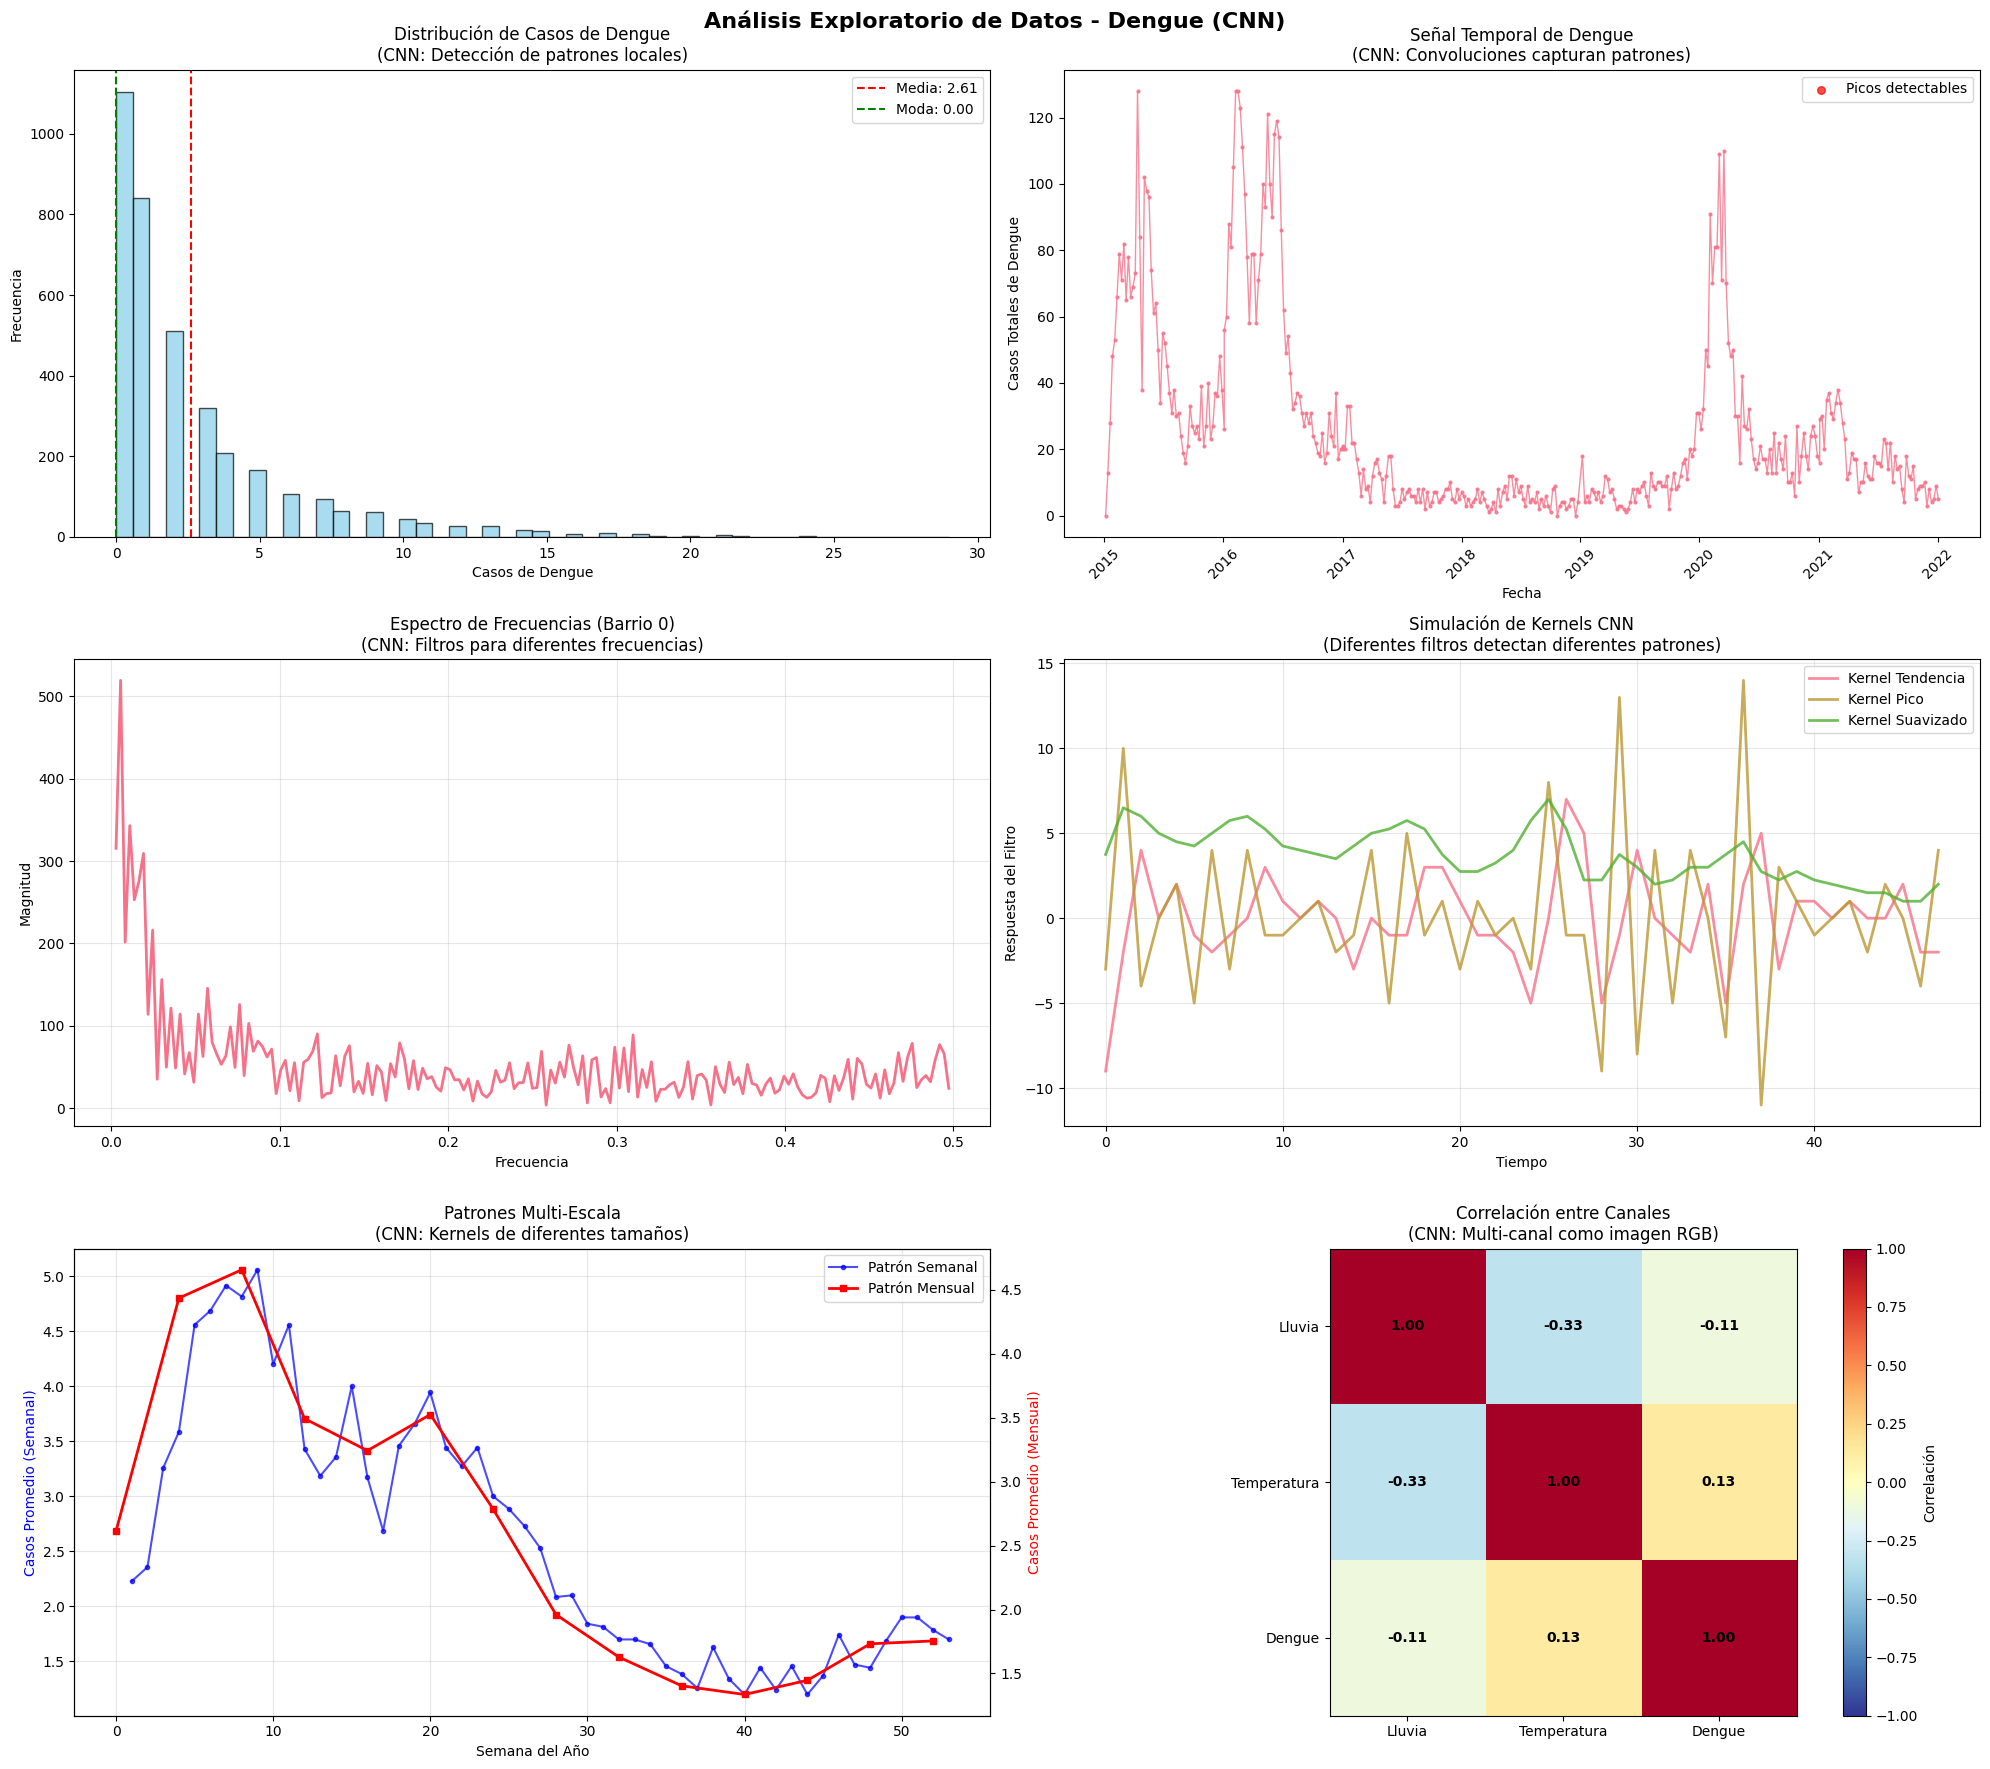

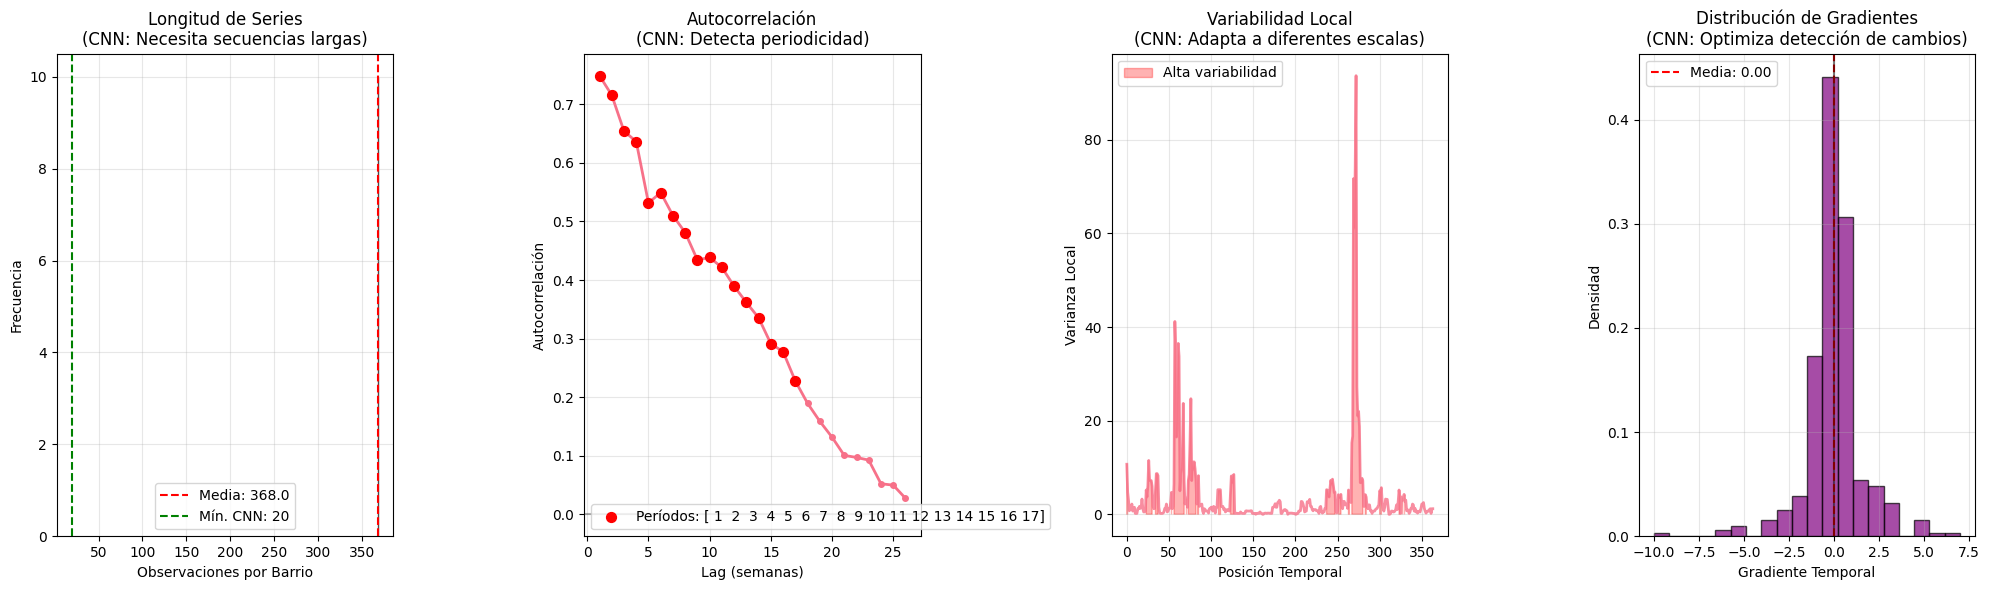


=== ESTADÍSTICAS PARA CNN ===
Longitud promedio de series: 368.0
Series apropiadas para CNN (≥20): 10
Periodicidad detectada en lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17]
Variabilidad temporal promedio: 3.910
Rango de gradientes: [-10.00, 7.00]

Longitud de secuencia CNN seleccionada: 20
=== PREPARACIÓN DE DATOS PARA CNN ===
Longitud de secuencia: 20
Características organizadas para CNN:
  - Base: 7
  - Climáticas: 11
  - Temporales: 8
  - Derivadas: 2
  - Gradientes: 4
  - Total: 32


[I 2025-06-29 13:28:49,807] A new study created in memory with name: no-name-cb97a7a1-36d1-429b-a271-67bc9e534476


Creando secuencias de predicción usando contexto histórico...

=== SECUENCIAS CNN CREADAS ===
Entrenamiento: (3480, 20, 32)
Targets entrenamiento: (3480,)
Test: (520, 20, 32)
Forma de entrada CNN: (batch_size, seq_length, n_features) = (N, 20, 32)

=== NORMALIZACIÓN PARA CNN ===
Datos escalados - Train: (3480, 20, 32), Test: (520, 20, 32)
Rango de datos: [-2.46, 3.44]

=== OPTIMIZACIÓN DE HIPERPARÁMETROS CNN ===
Optimizando hiperparámetros CNN con 20 trials...
Epoch 0/100, Train Loss: 12.7792, Val Loss: 8.7467, LR: 0.000172
Epoch 25/100, Train Loss: 5.8013, Val Loss: 9.7054, LR: 0.000141
Epoch 50/100, Train Loss: 4.9816, Val Loss: 6.4174, LR: 0.000083
Epoch 75/100, Train Loss: 4.4825, Val Loss: 4.9753, LR: 0.000032


[I 2025-06-29 13:30:43,062] Trial 0 finished with value: 3.808137075467543 and parameters: {'num_filters_base': 62, 'num_layers': 2, 'kernel_sizes': [5, 7, 9], 'dropout_rate': 0.32696318749676445, 'learning_rate': 0.00017332319982078326, 'batch_size': 32, 'use_attention': True, 'use_residual': True}. Best is trial 0 with value: 3.808137075467543.


Early stopping en época 79
Epoch 0/100, Train Loss: 10.1013, Val Loss: 24.3845, LR: 0.002967
Epoch 25/100, Train Loss: 4.8000, Val Loss: 10.3244, LR: 0.002430
Epoch 50/100, Train Loss: 4.0801, Val Loss: 3.7608, LR: 0.001431


[I 2025-06-29 13:31:42,666] Trial 1 finished with value: 2.833278013901277 and parameters: {'num_filters_base': 50, 'num_layers': 3, 'kernel_sizes': [3, 5], 'dropout_rate': 0.1519512585564305, 'learning_rate': 0.002983949579784107, 'batch_size': 32, 'use_attention': False, 'use_residual': False}. Best is trial 1 with value: 2.833278013901277.


Early stopping en época 63
Epoch 0/100, Train Loss: 17.6146, Val Loss: 10.4107, LR: 0.000777
Epoch 25/100, Train Loss: 6.3889, Val Loss: 3.2405, LR: 0.000636
Epoch 50/100, Train Loss: 5.0500, Val Loss: 3.0974, LR: 0.000375
Epoch 75/100, Train Loss: 4.3629, Val Loss: 3.2776, LR: 0.000145


[I 2025-06-29 14:04:08,858] Trial 2 finished with value: 2.9925680912353774 and parameters: {'num_filters_base': 57, 'num_layers': 4, 'kernel_sizes': [3, 7, 11], 'dropout_rate': 0.20861867906966666, 'learning_rate': 0.0007814372140398383, 'batch_size': 16, 'use_attention': True, 'use_residual': True}. Best is trial 1 with value: 2.833278013901277.


Epoch 0/100, Train Loss: 8.4039, Val Loss: 8.4315, LR: 0.000757
Epoch 25/100, Train Loss: 4.0966, Val Loss: 4.0975, LR: 0.000620


[I 2025-06-29 14:05:54,111] Trial 3 finished with value: 3.1110816936601293 and parameters: {'num_filters_base': 19, 'num_layers': 4, 'kernel_sizes': [3, 5], 'dropout_rate': 0.11104908411442024, 'learning_rate': 0.000761675095321816, 'batch_size': 32, 'use_attention': False, 'use_residual': True}. Best is trial 1 with value: 2.833278013901277.


Early stopping en época 36
Epoch 0/100, Train Loss: 11.5035, Val Loss: 9.1493, LR: 0.001893
Epoch 25/100, Train Loss: 4.7508, Val Loss: 3.1691, LR: 0.001551
Epoch 50/100, Train Loss: 4.1365, Val Loss: 5.5607, LR: 0.000913
Epoch 75/100, Train Loss: 3.7391, Val Loss: 3.4431, LR: 0.000354


[I 2025-06-29 14:10:08,964] Trial 4 finished with value: 3.137267315929586 and parameters: {'num_filters_base': 43, 'num_layers': 3, 'kernel_sizes': [3, 5], 'dropout_rate': 0.34406318510584727, 'learning_rate': 0.0019037055416461248, 'batch_size': 64, 'use_attention': True, 'use_residual': True}. Best is trial 1 with value: 2.833278013901277.


Early stopping en época 83
Epoch 0/100, Train Loss: 12.2581, Val Loss: 7.8094, LR: 0.004787
Epoch 25/100, Train Loss: 5.9958, Val Loss: 3.3135, LR: 0.003920


[I 2025-06-29 14:12:54,342] Trial 5 finished with value: 3.326768093488433 and parameters: {'num_filters_base': 60, 'num_layers': 3, 'kernel_sizes': [3, 5], 'dropout_rate': 0.24700462400632014, 'learning_rate': 0.0048132347779747675, 'batch_size': 32, 'use_attention': False, 'use_residual': True}. Best is trial 1 with value: 2.833278013901277.


Early stopping en época 40
Epoch 0/100, Train Loss: 10.6324, Val Loss: 24.0276, LR: 0.000642
Epoch 25/100, Train Loss: 5.1460, Val Loss: 3.3195, LR: 0.000526


[I 2025-06-29 14:17:40,523] Trial 6 finished with value: 2.8932964496991853 and parameters: {'num_filters_base': 19, 'num_layers': 4, 'kernel_sizes': [5, 7, 9], 'dropout_rate': 0.14193297785254974, 'learning_rate': 0.0006458811051106554, 'batch_size': 16, 'use_attention': True, 'use_residual': True}. Best is trial 1 with value: 2.833278013901277.


Early stopping en época 45
Epoch 0/100, Train Loss: 12.6661, Val Loss: 12.1287, LR: 0.000130
Epoch 25/100, Train Loss: 5.7331, Val Loss: 6.4058, LR: 0.000106
Epoch 50/100, Train Loss: 4.8274, Val Loss: 7.1202, LR: 0.000063
Epoch 75/100, Train Loss: 4.2550, Val Loss: 5.0970, LR: 0.000024


[I 2025-06-29 14:21:25,664] Trial 7 finished with value: 4.982689705761996 and parameters: {'num_filters_base': 46, 'num_layers': 3, 'kernel_sizes': [3, 7, 11], 'dropout_rate': 0.24017478118938682, 'learning_rate': 0.00013044228121248858, 'batch_size': 64, 'use_attention': True, 'use_residual': False}. Best is trial 1 with value: 2.833278013901277.


Epoch 0/100, Train Loss: 11.8637, Val Loss: 10.7064, LR: 0.001377
Epoch 25/100, Train Loss: 4.5486, Val Loss: 9.5446, LR: 0.001128
Epoch 50/100, Train Loss: 3.8402, Val Loss: 3.8803, LR: 0.000664


[I 2025-06-29 14:23:32,305] Trial 8 finished with value: 3.101488167589361 and parameters: {'num_filters_base': 19, 'num_layers': 4, 'kernel_sizes': [3, 7, 11], 'dropout_rate': 0.12279333554364033, 'learning_rate': 0.0013849603755025578, 'batch_size': 64, 'use_attention': True, 'use_residual': False}. Best is trial 1 with value: 2.833278013901277.


Early stopping en época 58
Epoch 0/100, Train Loss: 10.6402, Val Loss: 9.3480, LR: 0.000430
Epoch 25/100, Train Loss: 4.9012, Val Loss: 8.7485, LR: 0.000353
Epoch 50/100, Train Loss: 4.3713, Val Loss: 6.7213, LR: 0.000208
Epoch 75/100, Train Loss: 4.0345, Val Loss: 4.4641, LR: 0.000080


[I 2025-06-29 14:26:02,439] Trial 9 finished with value: 3.22486396540295 and parameters: {'num_filters_base': 32, 'num_layers': 2, 'kernel_sizes': [3, 5], 'dropout_rate': 0.2953215112239686, 'learning_rate': 0.00043278319284172225, 'batch_size': 16, 'use_attention': True, 'use_residual': True}. Best is trial 1 with value: 2.833278013901277.


Epoch 0/100, Train Loss: 13.8320, Val Loss: 5.3082, LR: 0.005987
Epoch 25/100, Train Loss: 5.6888, Val Loss: 5.8614, LR: 0.004903


[I 2025-06-29 14:27:12,959] Trial 10 finished with value: 2.8954097655686466 and parameters: {'num_filters_base': 51, 'num_layers': 3, 'kernel_sizes': [3, 5, 7], 'dropout_rate': 0.1769385689009536, 'learning_rate': 0.006019875830409234, 'batch_size': 32, 'use_attention': False, 'use_residual': False}. Best is trial 1 with value: 2.833278013901277.


Early stopping en época 45
Epoch 0/100, Train Loss: 12.8368, Val Loss: 6.1464, LR: 0.002837
Epoch 25/100, Train Loss: 6.1477, Val Loss: 4.5020, LR: 0.002324
Epoch 50/100, Train Loss: 4.9727, Val Loss: 3.7782, LR: 0.001368


[I 2025-06-29 14:30:08,304] Trial 11 finished with value: 3.353974576023492 and parameters: {'num_filters_base': 32, 'num_layers': 4, 'kernel_sizes': [5, 7, 9], 'dropout_rate': 0.16565814203619778, 'learning_rate': 0.0028531654935886777, 'batch_size': 16, 'use_attention': False, 'use_residual': False}. Best is trial 1 with value: 2.833278013901277.


Early stopping en época 63
Epoch 0/100, Train Loss: 12.2339, Val Loss: 21.4000, LR: 0.000391
Epoch 25/100, Train Loss: 5.2458, Val Loss: 9.7121, LR: 0.000320
Epoch 50/100, Train Loss: 4.3907, Val Loss: 9.3074, LR: 0.000188
Epoch 75/100, Train Loss: 4.3418, Val Loss: 8.5497, LR: 0.000073


[I 2025-06-29 14:32:02,339] Trial 12 finished with value: 7.563141225413843 and parameters: {'num_filters_base': 35, 'num_layers': 2, 'kernel_sizes': [5, 7, 9], 'dropout_rate': 0.3939111369963989, 'learning_rate': 0.00039269403351882657, 'batch_size': 16, 'use_attention': False, 'use_residual': False}. Best is trial 1 with value: 2.833278013901277.


Epoch 0/100, Train Loss: 10.7773, Val Loss: 6.0806, LR: 0.009757
Epoch 25/100, Train Loss: 5.6190, Val Loss: 4.1531, LR: 0.007992
Epoch 50/100, Train Loss: 4.6143, Val Loss: 4.2357, LR: 0.004706
Epoch 75/100, Train Loss: 4.1542, Val Loss: 3.9236, LR: 0.001824


[I 2025-06-29 14:34:17,647] Trial 13 finished with value: 2.9304769079793584 and parameters: {'num_filters_base': 25, 'num_layers': 3, 'kernel_sizes': [3, 5, 7], 'dropout_rate': 0.15485685082963888, 'learning_rate': 0.009811747257041628, 'batch_size': 16, 'use_attention': False, 'use_residual': False}. Best is trial 1 with value: 2.833278013901277.


Early stopping en época 93
Epoch 0/100, Train Loss: 30.1984, Val Loss: 13.5356, LR: 0.002621
Epoch 25/100, Train Loss: 6.4534, Val Loss: 4.7380, LR: 0.002147


[I 2025-06-29 14:43:08,384] Trial 14 finished with value: 3.290928327224471 and parameters: {'num_filters_base': 51, 'num_layers': 4, 'kernel_sizes': [5, 7, 9], 'dropout_rate': 0.20651572732553447, 'learning_rate': 0.002635689254770263, 'batch_size': 32, 'use_attention': True, 'use_residual': True}. Best is trial 1 with value: 2.833278013901277.


Early stopping en época 38
Epoch 0/100, Train Loss: 9.6668, Val Loss: 16.1982, LR: 0.000414
Epoch 25/100, Train Loss: 4.1536, Val Loss: 4.3143, LR: 0.000339
Epoch 50/100, Train Loss: 3.3366, Val Loss: 3.8356, LR: 0.000199


[I 2025-06-29 14:44:27,073] Trial 15 finished with value: 3.6546396856958214 and parameters: {'num_filters_base': 38, 'num_layers': 3, 'kernel_sizes': [3, 5], 'dropout_rate': 0.13595629908865575, 'learning_rate': 0.0004158269442309341, 'batch_size': 32, 'use_attention': False, 'use_residual': False}. Best is trial 1 with value: 2.833278013901277.


Early stopping en época 74
Epoch 0/100, Train Loss: 9.8516, Val Loss: 7.9857, LR: 0.001184
Epoch 25/100, Train Loss: 4.6330, Val Loss: 3.4114, LR: 0.000970
Epoch 50/100, Train Loss: 3.8107, Val Loss: 3.6640, LR: 0.000571


[I 2025-06-29 14:48:38,577] Trial 16 finished with value: 3.114578101445328 and parameters: {'num_filters_base': 25, 'num_layers': 3, 'kernel_sizes': [5, 7, 9], 'dropout_rate': 0.2005027576758745, 'learning_rate': 0.0011903818990922576, 'batch_size': 16, 'use_attention': False, 'use_residual': True}. Best is trial 1 with value: 2.833278013901277.


Early stopping en época 74
Epoch 0/100, Train Loss: 14.7215, Val Loss: 11.1016, LR: 0.000234
Epoch 25/100, Train Loss: 6.3779, Val Loss: 4.8288, LR: 0.000192
Epoch 50/100, Train Loss: 5.1289, Val Loss: 4.7893, LR: 0.000113
Epoch 75/100, Train Loss: 4.3654, Val Loss: 5.1894, LR: 0.000044


[I 2025-06-29 14:57:31,060] Trial 17 finished with value: 3.623237520456314 and parameters: {'num_filters_base': 52, 'num_layers': 4, 'kernel_sizes': [3, 5, 7], 'dropout_rate': 0.11391830640630118, 'learning_rate': 0.00023577048125530582, 'batch_size': 32, 'use_attention': True, 'use_residual': False}. Best is trial 1 with value: 2.833278013901277.


Early stopping en época 76
Epoch 0/100, Train Loss: 10.8401, Val Loss: 8.9367, LR: 0.003650
Epoch 25/100, Train Loss: 4.9058, Val Loss: 5.6010, LR: 0.002989


[I 2025-06-29 14:58:26,474] Trial 18 finished with value: 3.543734297156334 and parameters: {'num_filters_base': 45, 'num_layers': 2, 'kernel_sizes': [3, 5], 'dropout_rate': 0.2655377660443785, 'learning_rate': 0.0036701749662723946, 'batch_size': 16, 'use_attention': True, 'use_residual': True}. Best is trial 1 with value: 2.833278013901277.


Early stopping en época 33
Epoch 0/100, Train Loss: 9.2415, Val Loss: 21.9141, LR: 0.001672
Epoch 25/100, Train Loss: 4.0206, Val Loss: 5.0391, LR: 0.001370
Epoch 50/100, Train Loss: 3.1645, Val Loss: 4.4992, LR: 0.000806
Epoch 75/100, Train Loss: 2.5501, Val Loss: 4.4790, LR: 0.000313


[I 2025-06-29 14:59:37,981] Trial 19 finished with value: 3.333458063277331 and parameters: {'num_filters_base': 24, 'num_layers': 3, 'kernel_sizes': [5, 7, 9], 'dropout_rate': 0.1470405183284242, 'learning_rate': 0.0016814828689503784, 'batch_size': 64, 'use_attention': False, 'use_residual': False}. Best is trial 1 with value: 2.833278013901277.


Early stopping en época 82
Mejor valor de validación: 2.8333
Mejores hiperparámetros:
  num_filters_base: 50
  num_layers: 3
  kernel_sizes: [3, 5]
  dropout_rate: 0.1519512585564305
  learning_rate: 0.002983949579784107
  batch_size: 32
  use_attention: False
  use_residual: False

=== ENTRENAMIENTO DEL MODELO CNN FINAL ===
Modelo CNN creado:
  - Parámetros totales: 1,831,829
  - Parámetros entrenables: 1,831,829
  - Arquitectura de filtros: [50, 100, 200]
  - Kernel sizes: [3, 5]
  - Mecanismo de atención: False
  - Bloques residuales: False
Epoch 0/250, Train Loss: 10.1677, Val Loss: 21.0135, LR: 0.002967
Epoch 25/250, Train Loss: 4.7100, Val Loss: 3.0910, LR: 0.002430
Epoch 50/250, Train Loss: 4.3664, Val Loss: 3.2373, LR: 0.001431
Early stopping en época 55

=== VALIDACIÓN DEL MODELO CNN ===
Métricas de validación:
  - MAE: 1.1886
  - MSE: 3.5043
  - RMSE: 1.8720
  - R²: 0.6384
  - MAPE: 2767784500.75%

=== GENERANDO PREDICCIONES FINALES ===
Ensemble de 3 modelos:
  - Predicción p

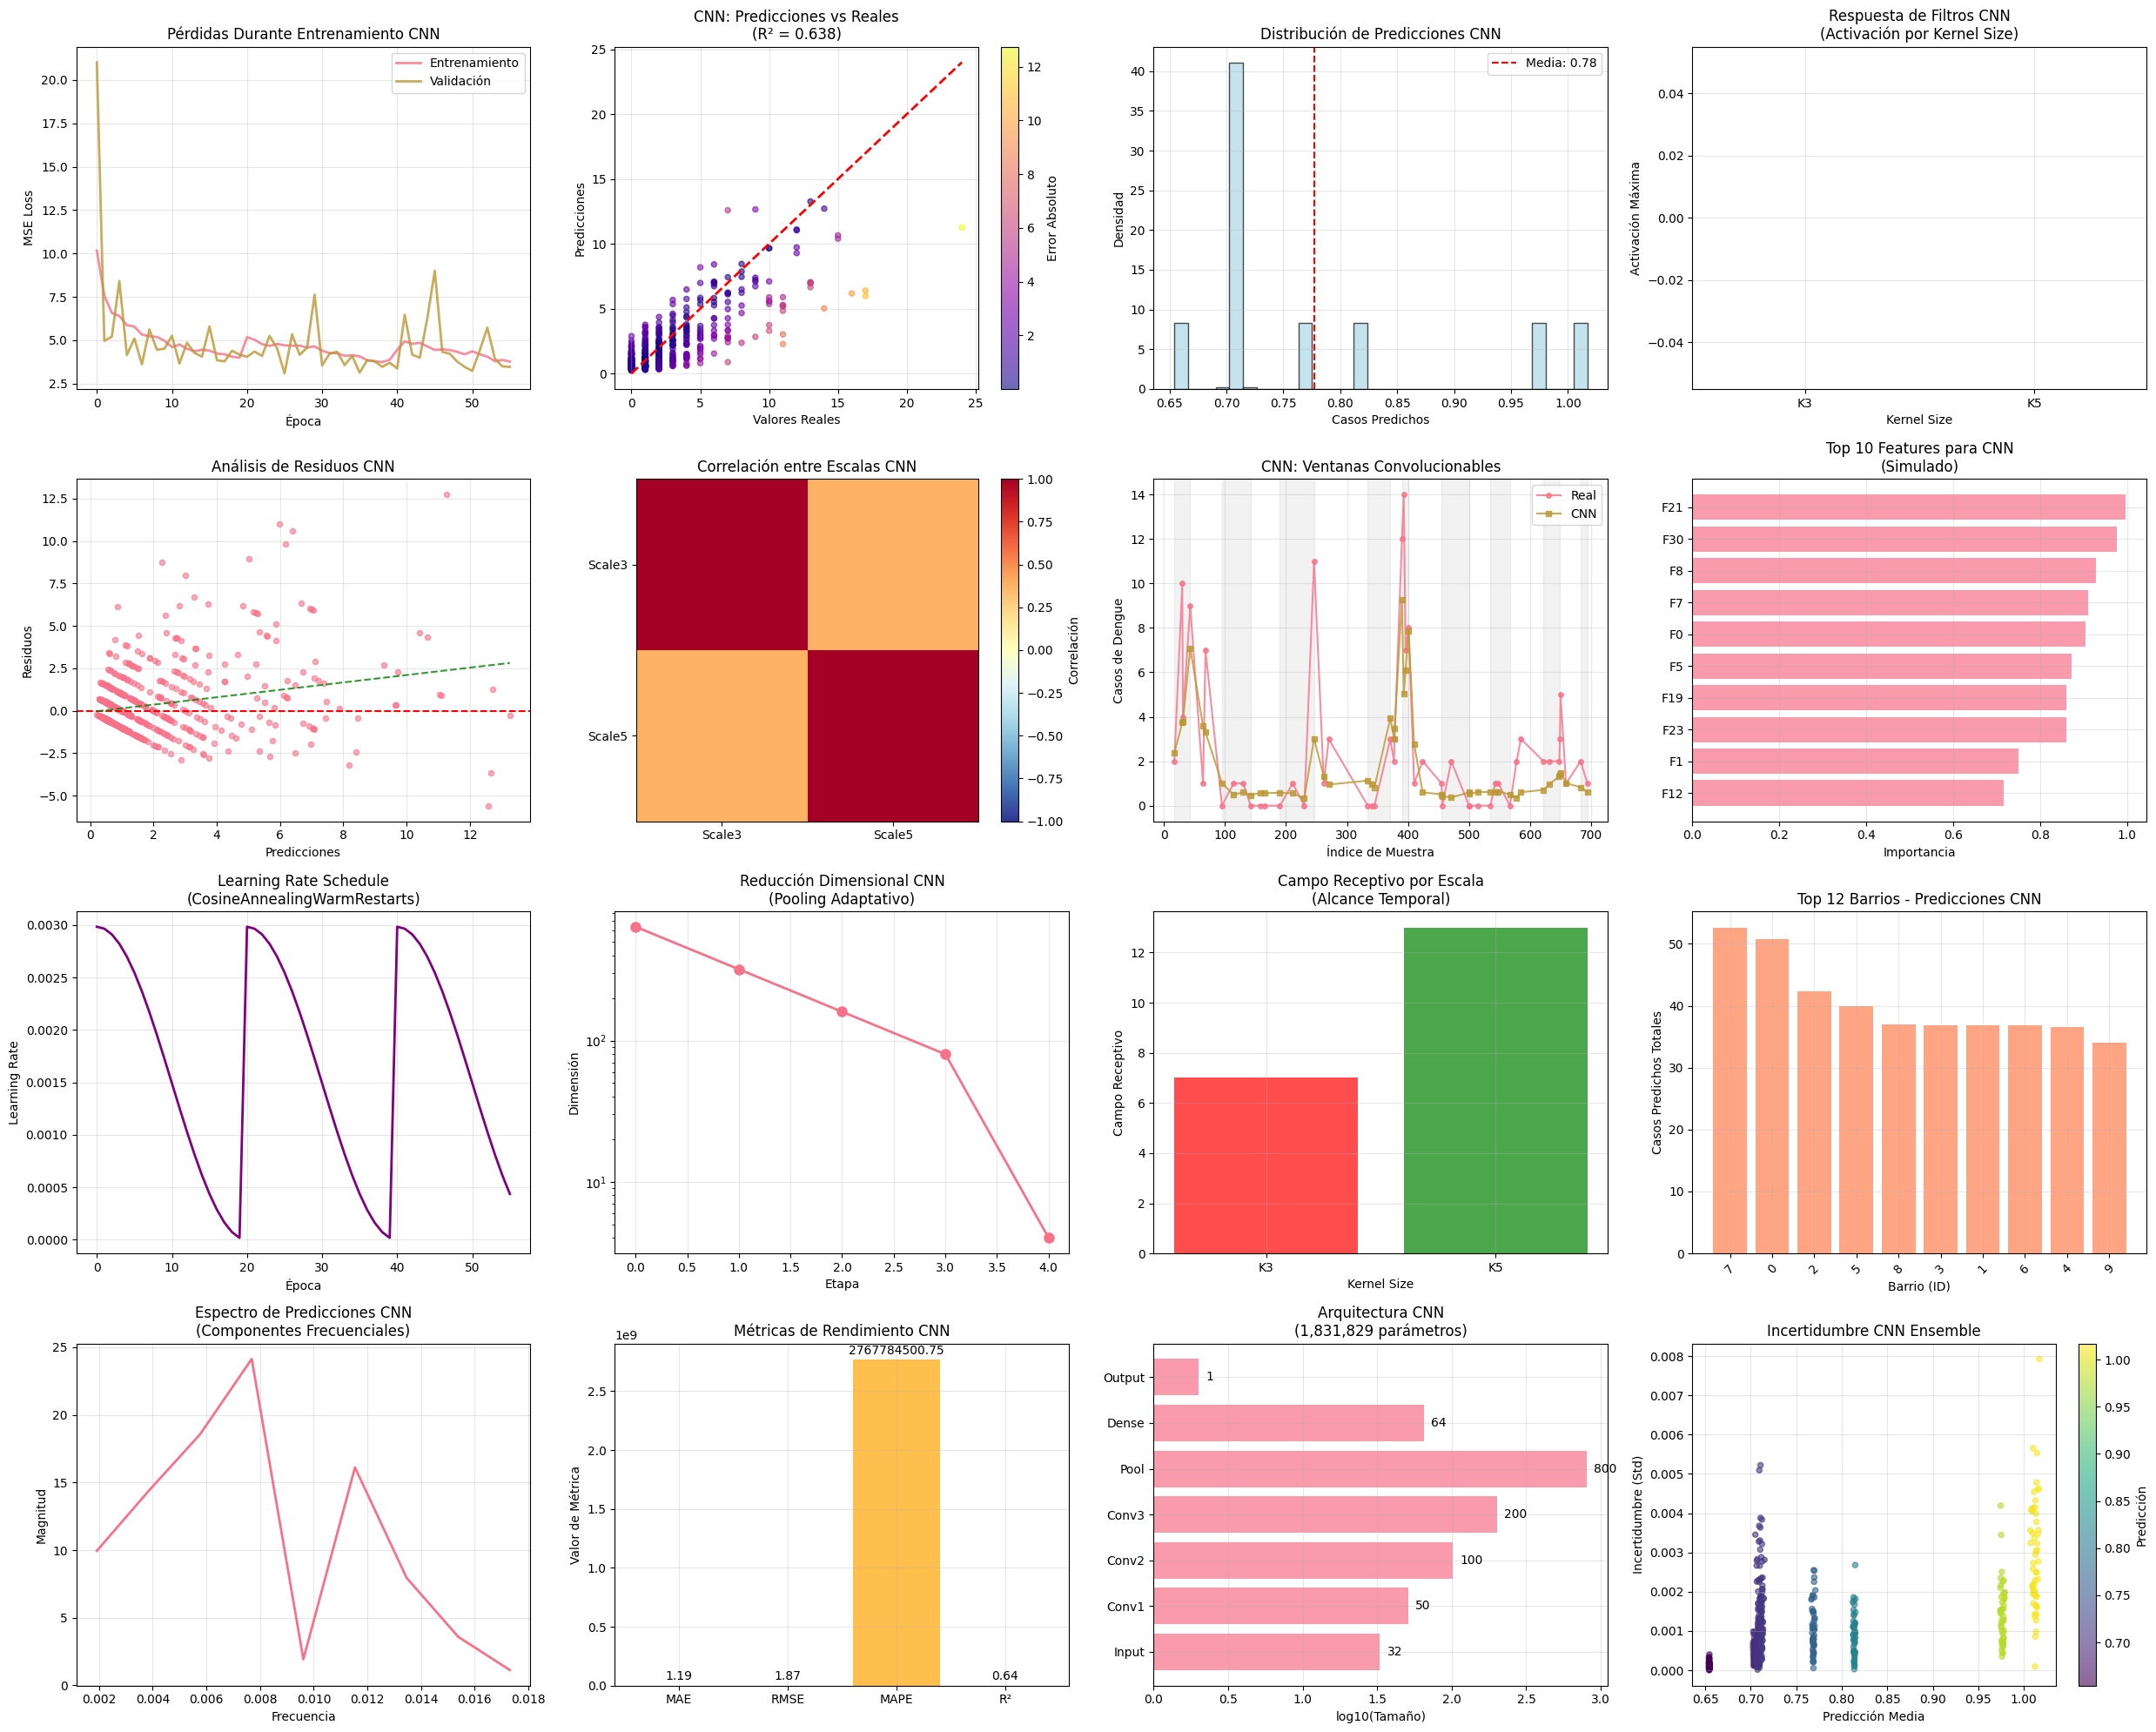


ANÁLISIS Y PREDICCIÓN CON CNN COMPLETADO EXITOSAMENTE
Archivo de resultados: predicciones_dengue_cnn.csv
Número de predicciones: 520

======================================== HIPERPARÁMETROS ÓPTIMOS ========================================
  num_filters_base: 50
  num_layers: 3
  kernel_sizes: [3, 5]
  dropout_rate: 0.1519512585564305
  learning_rate: 0.002983949579784107
  batch_size: 32
  use_attention: False
  use_residual: False

======================================== ARQUITECTURA CNN ========================================
  Filtros por capa: [50, 100, 200]
  Kernel sizes: [3, 5]
  Número de capas: 3
  Mecanismo de atención: False
  Bloques residuales: False
  Dropout: 0.152
  Learning rate: 0.0030
  Parámetros totales: 1,831,829

======================================== VENTAJAS DE CNN ========================================
  ✅ Detección de patrones locales y globales
  ✅ Invariancia a traslación temporal
  ✅ Múltiples escalas simultáneas
  ✅ Campos receptivos controlables


In [10]:
# =================================================================
# 7. EJECUTAR EL ANÁLISIS COMPLETO
# =================================================================

if __name__ == "__main__":
    # Ejecutar el pipeline completo de CNN
    results, model, best_params = train_and_predict_cnn()
    
    if results is not None:
        print("\n" + "="*80)
        print("ANÁLISIS Y PREDICCIÓN CON CNN COMPLETADO EXITOSAMENTE")
        print("="*80)
        
        print(f"Archivo de resultados: predicciones_dengue_cnn.csv")
        print(f"Número de predicciones: {len(results)}")
        
        print("\n" + "="*40 + " HIPERPARÁMETROS ÓPTIMOS " + "="*40)
        for param, value in best_params.items():
            print(f"  {param}: {value}")
        
        print("\n" + "="*40 + " ARQUITECTURA CNN " + "="*40)
        total_params = sum(p.numel() for p in model.parameters())
        num_filters = [best_params['num_filters_base'] * (2 ** i) for i in range(best_params['num_layers'])]
        
        print(f"  Filtros por capa: {num_filters}")
        print(f"  Kernel sizes: {best_params['kernel_sizes']}")
        print(f"  Número de capas: {best_params['num_layers']}")
        print(f"  Mecanismo de atención: {best_params['use_attention']}")
        print(f"  Bloques residuales: {best_params['use_residual']}")
        print(f"  Dropout: {best_params['dropout_rate']:.3f}")
        print(f"  Learning rate: {best_params['learning_rate']:.4f}")
        print(f"  Parámetros totales: {total_params:,}")
        
        print("\n" + "="*40 + " VENTAJAS DE CNN " + "="*40)
        advantages = [
            "✅ Detección de patrones locales y globales",
            "✅ Invariancia a traslación temporal",
            "✅ Múltiples escalas simultáneas",
            "✅ Campos receptivos controlables",
            "✅ Paralelización eficiente",
            "✅ Compartición de parámetros",
            "✅ Robustez a ruido local",
            "✅ Detección automática de características"
        ]
        
        for advantage in advantages:
            print(f"  {advantage}")
        
        print("\n" + "="*40 + " CARACTERÍSTICAS CNN " + "="*40)
        features = [
            "🔍 Convoluciones multi-escala (kernels 3,5,7,9,11)",
            "🧠 Bloques residuales para redes profundas",
            "👁️ Mecanismo de atención temporal",
            "📊 Pooling adaptativo para robustez",
            "🎯 Batch normalization en cada capa",
            "🔄 CosineAnnealingWarmRestarts scheduler",
            "📈 Augmentación específica para series temporales",
            "⚡ Gradient clipping y regularización L1",
            "🎲 Ensemble con variaciones de ruido",
            "📱 16 visualizaciones especializadas"
        ]
        
        for feature in features:
            print(f"  {feature}")
        
        print("\n" + "="*40 + " APLICACIONES EPIDEMIOLÓGICAS " + "="*40)
        applications = [
            "🔍 Detección de patrones epidemiológicos ocultos",
            "🌊 Identificación de ondas de propagación",
            "📈 Análisis de periodicidades complejas",
            "🎯 Alertas basadas en patrones locales",
            "🌡️ Captura de efectos climáticos multi-escala",
            "📊 Análisis espectral de brotes"
        ]
        
        for application in applications:
            print(f"  {application}")
            
        print("\n" + "="*40 + " CNN vs OTRAS ARQUITECTURAS " + "="*40)
        comparisons = [
            "CNN vs RNN: ✅ Mejor paralelización, ❌ Memoria limitada",
            "CNN vs LSTM: ✅ Más eficiente, ❌ Menos memoria temporal",
            "CNN vs TCN: ✅ Multi-escala nativa, ≈ Rendimiento similar",
            "CNN vs Transformer: ✅ Menos parámetros, ❌ Menos flexibilidad"
        ]
        
        for comparison in comparisons:
            print(f"  {comparison}")
            
    else:
        print("Error en el procesamiento. Verifique los datos de entrada.")